#车杆平衡问题:CartPole-V0

- 问题描述：一个小车可以在直线滑轨上移动，一个杆子一头连着小车，另外一头悬空，可以不完全智力。小车的初始位置和杆子的初始角度都是在一定范围内随机选取的。
- 智能体可以控制小车沿着滑轨左移一个单位或者右移1段固定长度，不可以不移动。
- 出现以下情形中的任一情形时，回合结束：
  - 杆子的倾斜角超过12°；
  - 小车移动超过2.4个单位长度；
  - 一个回合内达到200步；
- 每进行一步得到一个单位的奖励，希望回合尽量长。目标希望100个回合平均奖励超过195.

In [1]:
# 日志初始化
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
logging.info('logging test')

2020-06-13 03:52:30,295 : INFO : logging test


In [0]:
%matplotlib inline

In [0]:
import gym
import numpy as np

In [4]:
env = gym.make('CartPole-v0')
logging.info('观测空间：{}'.format(env.observation_space))
logging.info('动作空间：{}'.format(env.action_space))
logging.info('观测范围：{}至{}'.format(env.observation_space.low, env.observation_space.high))
logging.info('动作数：{}'.format(env.action_space.n))

2020-06-13 03:52:31,120 : INFO : 观测空间：Box(4,)
2020-06-13 03:52:31,121 : INFO : 动作空间：Discrete(2)
2020-06-13 03:52:31,122 : INFO : 观测范围：[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]至[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
2020-06-13 03:52:31,123 : INFO : 动作数：2


- 观察值有4个分量，分别是小车位置、小车速度、杆子角度、杆子角速度。
- 动作取值为0或1，分别表示向左和向右。

## 随机策略

In [0]:
def play(env, render=False):
    episode_reward = 0
    observation = env.reset()
    step = 0
    while True:
        if render:
            env.render()
        action = env.action_space.sample()
        next_observation, reward, done, _ = env.step(action)
        
        episode_reward += reward
        if done:
            break
        step += 1
        observation = next_observation
    return episode_reward

In [6]:
# 测试
logging.info('使用随机策略进行测试')
episode_rewards = [play(env, render=False) for _ in range(100)]
logging.info('平均奖励为{}/{}={}'.format(sum(episode_rewards), len(episode_rewards), np.mean(episode_rewards)))

2020-06-13 03:52:31,142 : INFO : 使用随机策略进行测试
2020-06-13 03:52:31,175 : INFO : 平均奖励为2174.0/100=21.74


## A2C算法
- 优势执行者/评论者算法（Advantage Actor-Critic，A2C）

In [0]:
import matplotlib.pyplot as plt

import tensorflow.compat.v2 as tf
from tensorflow import keras

In [0]:
class RewardChart:
    """训练时奖励变化绘图工具类"""
    def __init__(self):
        self.fig, self.ax = plt.subplots(1, 1)

    def plot(self, episode_rewards):
        self.ax.clear()
        self.ax.plot(episode_rewards)
        self.ax.set_xlabel('iteration')
        self.ax.set_ylabel('episode reward')
        self.fig.canvas.draw()

In [9]:
# 输入是一个状态，是CartPole的位置、速度、角度和角速度四个变量
observation = env.reset()
# np.newaxis 在使用和功能上等价于 None
input_shape = tf.convert_to_tensor(observation[np.newaxis], dtype=tf.float32).get_shape()
logging.info('input_shape:{}'.format(input_shape))

2020-06-13 03:52:33,136 : INFO : input_shape:(1, 4)


In [10]:
# 构造执行者网络
output_size = env.action_space.n  # 输出为动作空间
logging.info('output_size:{}'.format(output_size))
actor_net = keras.Sequential()
# A linear layer
actor_net.add(keras.layers.Dense(units=32, activation=tf.nn.relu))
# actor_net.add(keras.layers.Dense(units=16, activation=tf.nn.relu))
actor_net.add(keras.layers.Dense(units=output_size, activation=tf.nn.softmax))
optimizer = tf.optimizers.Adam(0.001)  # 0.001 设置学习率
# 使用交叉熵计算loss
actor_net.compile(optimizer=optimizer, loss=tf.losses.categorical_crossentropy)
actor_net.build(input_shape)
actor_net.summary()

2020-06-13 03:52:33,147 : INFO : output_size:2


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  160       
_________________________________________________________________
dense_1 (Dense)              multiple                  66        
Total params: 226
Trainable params: 226
Non-trainable params: 0
_________________________________________________________________


In [11]:
# 构造评论者网络
output_size = 1  # 输出为状态价值
logging.info('output_size:{}'.format(output_size))
critic_net = keras.Sequential()
# A linear layer
critic_net.add(keras.layers.Dense(units=32, activation=tf.nn.relu))
# critic_net.add(keras.layers.Dense(units=16, activation=tf.nn.relu))
critic_net.add(keras.layers.Dense(units=output_size, activation=None))
optimizer = tf.optimizers.Adam(0.002)  # 0.002 设置学习率
# 使用mse计算loss
critic_net.compile(optimizer=optimizer, loss=tf.losses.mse)
critic_net.build(input_shape)
critic_net.summary()

2020-06-13 03:52:33,200 : INFO : output_size:1


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              multiple                  160       
_________________________________________________________________
dense_3 (Dense)              multiple                  33        
Total params: 193
Trainable params: 193
Non-trainable params: 0
_________________________________________________________________


In [0]:
class AdvantageActorCriticAgent(object):
    """A2C智能体"""
    def __init__(self, gamma=0.99):
        self.action_n = env.action_space.n
        self.gamma = gamma
        self.discount = 1.

    def decide(self, observation):
        """actor网络对observation进行预测，按概率求取下一步动作"""
        probs = actor_net.predict(observation[np.newaxis])[0]
        action = np.random.choice(self.action_n, p=probs)
        return action

    def learn(self, observation, action, reward, next_observation, done):
        x = observation[np.newaxis]
        next_x = next_observation[np.newaxis]
        next_x_tensor = tf.convert_to_tensor(next_x, dtype=tf.float32)
        # 使用critic网络计算observation与next_observation状态价值
        u = reward + (1. - done) * self.gamma * critic_net.predict(next_x_tensor)
        td_error = u - critic_net.predict(x)

        # 训练执行者网络
        x_tensor = tf.convert_to_tensor(observation[np.newaxis], dtype=tf.float32)
        # 使用梯度带计算梯度
        with tf.GradientTape() as tape:
            pi_tensor = actor_net(x_tensor)[0, action]
            logpi_tensor = tf.math.log(tf.clip_by_value(pi_tensor, 1e-6, 1.))
            loss_tensor = -self.discount * td_error * logpi_tensor
        grad_tensors = tape.gradient(loss_tensor, actor_net.variables)
        # 更新执行者网络
        actor_net.optimizer.apply_gradients(zip(grad_tensors, actor_net.variables))

        # 训练评论者网络
        critic_net.fit(x, u, verbose=0)  # 更新评论者网络

        if done:
            self.discount = 1.  # 为下一回合初始化累积折扣
        else:
            self.discount *= self.gamma  # 进一步累积折扣

In [0]:
def play_a2c(env, agent, train=False, render=False):
  episode_reward = 0
  observation = env.reset()
  step = 0
  while True:
    if render:
        env.render()
    action = agent.decide(observation)
    next_observation, reward, done, _ = env.step(action)
    episode_reward += reward
    if train:
        agent.learn(observation, action, reward, next_observation, done)
    if done:
        break
    step += 1
    observation = next_observation
  return episode_reward

2020-06-13 03:52:33,287 : INFO : 训练10轮
2020-06-13 03:52:35,542 : INFO : episode:1， episode_reward：17.0, average_reward:17.0
2020-06-13 03:52:37,000 : INFO : episode:2， episode_reward：15.0, average_reward:16.0
2020-06-13 03:52:38,771 : INFO : episode:3， episode_reward：19.0, average_reward:17.0
2020-06-13 03:52:40,007 : INFO : episode:4， episode_reward：13.0, average_reward:16.0
2020-06-13 03:52:42,574 : INFO : episode:5， episode_reward：27.0, average_reward:18.2
2020-06-13 03:52:46,062 : INFO : episode:6， episode_reward：36.0, average_reward:21.166666666666668
2020-06-13 03:52:47,738 : INFO : episode:7， episode_reward：18.0, average_reward:20.714285714285715
2020-06-13 03:52:48,645 : INFO : episode:8， episode_reward：10.0, average_reward:19.375
2020-06-13 03:52:49,549 : INFO : episode:9， episode_reward：10.0, average_reward:18.333333333333332
2020-06-13 03:52:51,186 : INFO : episode:10， episode_reward：18.0, average_reward:18.3
2020-06-13 03:53:31,976 : INFO : 平均奖励为1960.0/100=19.6


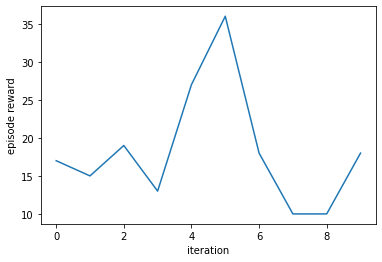

In [14]:
# 训练10轮
all_episodes = 0
logging.info('训练10轮')
episodes = 10
episode_rewards = []
chart = RewardChart()
agent = AdvantageActorCriticAgent()
start_episodes = all_episodes
stop_episodes = episodes + all_episodes
for episode in range(start_episodes, stop_episodes):
  all_episodes += 1
  episode_reward = play_a2c(env, agent, train=True)
  episode_rewards.append(episode_reward)
  logging.info('episode:{}， episode_reward：{}, average_reward:{}'.format(all_episodes, episode_reward, np.mean(episode_rewards)))
chart.plot(episode_rewards)
# 测试
episode_rewards = [play_a2c(env, agent) for _ in range(100)]
logging.info('平均奖励为{}/{}={}'.format(sum(episode_rewards), len(episode_rewards), np.mean(episode_rewards)))

2020-06-13 03:53:32,086 : INFO : 再训练50轮
2020-06-13 03:53:45,180 : INFO : episode:20， episode_reward：19.0, average_reward:19.09090909090909
2020-06-13 03:53:59,495 : INFO : episode:30， episode_reward：18.0, average_reward:18.791666666666668
2020-06-13 03:54:12,025 : INFO : episode:40， episode_reward：15.0, average_reward:18.376923076923077
2020-06-13 03:54:25,468 : INFO : episode:50， episode_reward：19.0, average_reward:18.107142857142858
2020-06-13 03:54:35,228 : INFO : episode:60， episode_reward：10.0, average_reward:17.606666666666666
2020-06-13 03:55:04,687 : INFO : 平均奖励为1410.0/100=14.1


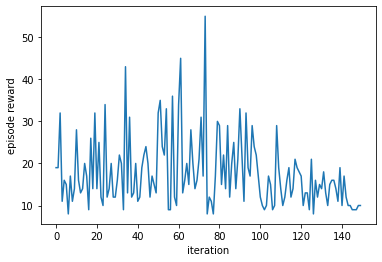

In [15]:
logging.info('再训练50轮')
episodes = 50
# episode_rewards = []
chart = RewardChart()
# agent = AdvantageActorCriticAgent()
start_episodes = all_episodes
stop_episodes = episodes + all_episodes
for episode in range(start_episodes, stop_episodes):
  all_episodes += 1
  episode_reward = play_a2c(env, agent, train=True)
  episode_rewards.append(episode_reward)
  if all_episodes % 10 == 0:
    logging.info('episode:{}， episode_reward：{}, average_reward:{}'.format(all_episodes, episode_reward, np.mean(episode_rewards)))
chart.plot(episode_rewards)
# 测试
episode_rewards = [play_a2c(env, agent) for _ in range(100)]
logging.info('平均奖励为{}/{}={}'.format(sum(episode_rewards), len(episode_rewards), np.mean(episode_rewards)))

2020-06-13 03:55:04,801 : INFO : 再训练100轮
2020-06-13 03:55:16,260 : INFO : episode:70， episode_reward：13.0, average_reward:13.945454545454545
2020-06-13 03:55:28,308 : INFO : episode:80， episode_reward：13.0, average_reward:13.866666666666667
2020-06-13 03:55:42,315 : INFO : episode:90， episode_reward：25.0, average_reward:13.96923076923077
2020-06-13 03:55:58,233 : INFO : episode:100， episode_reward：17.0, average_reward:14.2
2020-06-13 03:56:08,841 : INFO : episode:110， episode_reward：9.0, average_reward:14.026666666666667
2020-06-13 03:56:22,447 : INFO : episode:120， episode_reward：20.0, average_reward:14.05625
2020-06-13 03:56:41,494 : INFO : episode:130， episode_reward：65.0, average_reward:14.452941176470588
2020-06-13 03:57:12,658 : INFO : episode:140， episode_reward：44.0, average_reward:15.533333333333333
2020-06-13 03:57:33,083 : INFO : episode:150， episode_reward：19.0, average_reward:15.868421052631579
2020-06-13 03:58:02,231 : INFO : episode:160， episode_reward：26.0, average_rewa

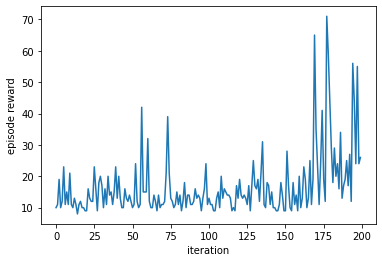

In [16]:
logging.info('再训练100轮')
episodes = 100
# episode_rewards = []
chart = RewardChart()
# agent = AdvantageActorCriticAgent()
start_episodes = all_episodes
stop_episodes = episodes + all_episodes
for episode in range(start_episodes, stop_episodes):
  all_episodes += 1
  episode_reward = play_a2c(env, agent, train=True)
  episode_rewards.append(episode_reward)
  if all_episodes % 10 == 0:
    logging.info('episode:{}， episode_reward：{}, average_reward:{}'.format(all_episodes, episode_reward, np.mean(episode_rewards)))
chart.plot(episode_rewards)
# 测试
episode_rewards = [play_a2c(env, agent) for _ in range(100)]
logging.info('平均奖励为{}/{}={}'.format(sum(episode_rewards), len(episode_rewards), np.mean(episode_rewards)))

2020-06-13 03:59:57,247 : INFO : 再训练200轮
2020-06-13 04:00:46,784 : INFO : episode:170， episode_reward：79.0, average_reward:54.61818181818182
2020-06-13 04:01:24,017 : INFO : episode:180， episode_reward：54.0, average_reward:53.458333333333336
2020-06-13 04:02:08,186 : INFO : episode:190， episode_reward：85.0, average_reward:53.02307692307692
2020-06-13 04:02:57,178 : INFO : episode:200， episode_reward：66.0, average_reward:53.1
2020-06-13 04:03:57,914 : INFO : episode:210， episode_reward：30.0, average_reward:53.95333333333333
2020-06-13 04:04:44,941 : INFO : episode:220， episode_reward：34.0, average_reward:53.775
2020-06-13 04:05:45,151 : INFO : episode:230， episode_reward：84.0, average_reward:54.5
2020-06-13 04:06:51,292 : INFO : episode:240， episode_reward：73.0, average_reward:55.44444444444444
2020-06-13 04:07:51,313 : INFO : episode:250， episode_reward：91.0, average_reward:55.963157894736845
2020-06-13 04:09:10,496 : INFO : episode:260， episode_reward：50.0, average_reward:57.455
2020-

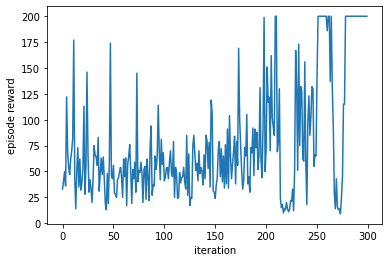

In [17]:
logging.info('再训练200轮')
episodes = 200
# episode_rewards = []
chart = RewardChart()
# agent = AdvantageActorCriticAgent()
start_episodes = all_episodes
stop_episodes = episodes + all_episodes
for episode in range(start_episodes, stop_episodes):
  all_episodes += 1
  episode_reward = play_a2c(env, agent, train=True)
  episode_rewards.append(episode_reward)
  if all_episodes % 10 == 0:
    logging.info('episode:{}， episode_reward：{}, average_reward:{}'.format(all_episodes, episode_reward, np.mean(episode_rewards)))
chart.plot(episode_rewards)
# 测试
episode_rewards = [play_a2c(env, agent) for _ in range(100)]
logging.info('平均奖励为{}/{}={}'.format(sum(episode_rewards), len(episode_rewards), np.mean(episode_rewards)))

370多轮训练后，目标为100个回合平均奖励超过195；模型结果为198.54，已到达预期目标。

In [0]:
# env.close()